In [1]:
%matplotlib notebook
import hyperspy.api as hs
import numpy as np

## Create some test data
- 50x50 array of Gaussians with randomly varying A, mu, and sigma

<IPython.core.display.Javascript object>


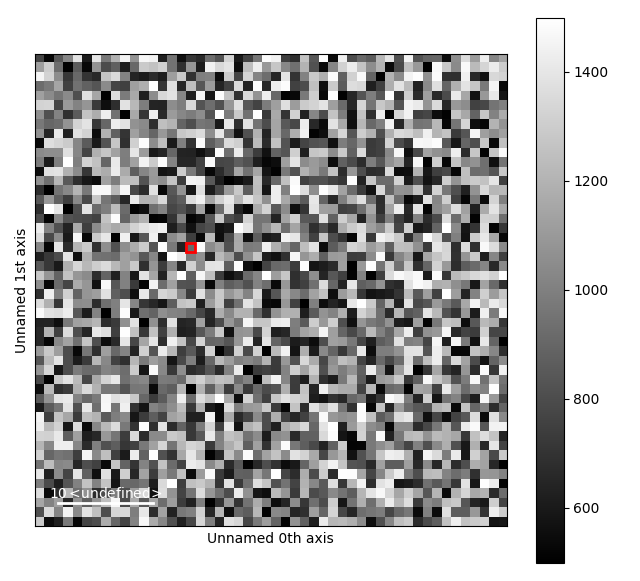

<IPython.core.display.Javascript object>


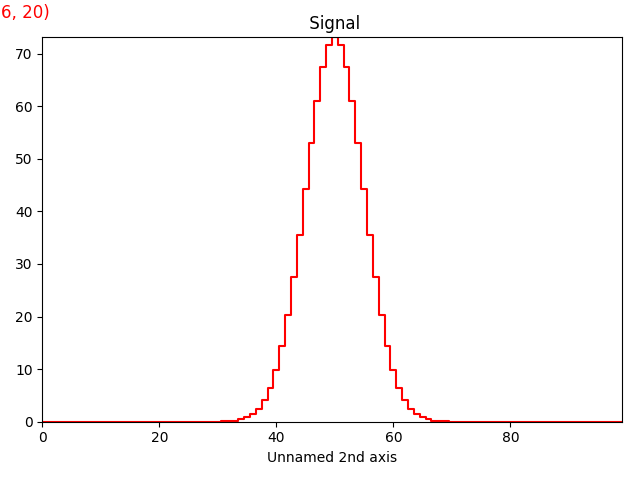

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [189]:
amps = hs.signals.Signal2D(np.random.randint(500,1500,size=[50,50]))
centers = hs.signals.Signal2D(np.random.randint(45,55,size=[50,50]))
sigmas = hs.signals.Signal2D(np.random.randint(5,10,size=[50,50]))

xaxis = np.tile(np.arange(0,100),50**2)
xaxis = xaxis.reshape([50,50,100])
xaxis = np.rollaxis(xaxis,2)
curves = amps.data/np.sqrt(2*np.pi*sigmas.data**2)*np.exp(-(xaxis-centers.data)**2/(2*sigmas.data**2))
curves = np.rollaxis(curves,0,3)
gaussians = hs.signals.Signal1D(curves)

gaussians.plot()

## Create a model
- Add single Gaussian component
- Perform fit at all pixel locations

In [4]:
gaussians_model = gaussians.create_model()
gaussians_model.append(hs.model.components1D.Gaussian())
gaussians_model.multifit()

gaussians_model.plot()

## Add some noise to the test data

In [174]:
noisy = gaussians.deepcopy()
noisy.unfold()

for i in range(0,50**2):
    noisy.data[i,:] =noisy.data[i,:] + np.random.poisson(np.sqrt(noisy.data[i,:].max()),100)
noisy.fold()

100%|█████████████████████████████████████| 2500/2500 [00:12<00:00, 194.22it/s]


## Create a model from the noisy data
- Add a single Gaussian component
- Add a lineaer offset to account for 'background' from adding noise
- Perform fit at all image pixels

<IPython.core.display.Javascript object>


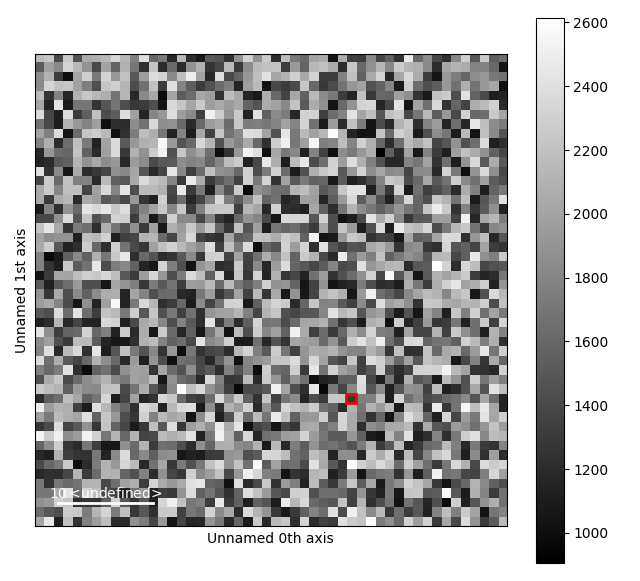

<IPython.core.display.Javascript object>


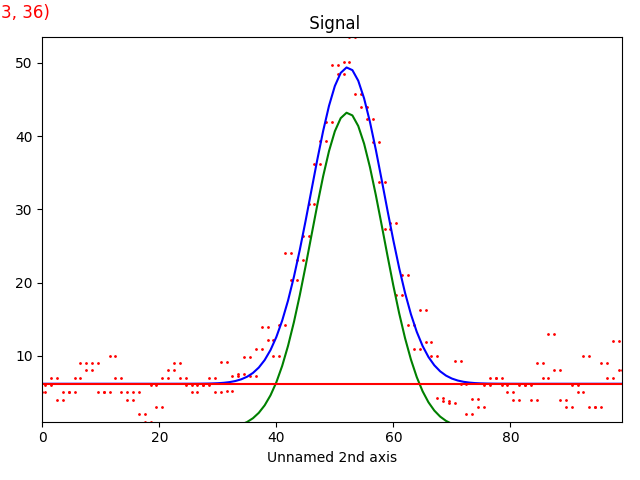

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [175]:
noisy_model = noisy.create_model()
noisy_model.append(hs.model.components1D.Gaussian())
noisy_model.append(hs.model.components1D.Offset())
noisy_model[0].estimate_parameters(noisy,10,90,False)
noisy_model[1].estimate_parameters(noisy,10,90,False)
noisy_model.multifit(show_progressbar=True)
noisy_model.plot(plot_components=True)

# More Realistic Application: Fitting EELS Fine Structure

## Load data downloaded from EELS Database
- https://eelsdb.eu/
    - Can be added directly using URL rather than downloading
- Set microscope parameters
- Add Boron and Nitrogen to model
- Create model
    - Automatically adds PowerLaw component to fit background
    - Automatically adds relevant edges in the energy range of the spectrum

In [184]:
s = hs.load("BN_(hex)_B_K_Giovanni_Bertoni_100.msa")
ll = hs.load("BN_(hex)_LowLoss_Giovanni_Bertoni_96.msa")

s.set_microscope_parameters(beam_energy=100, convergence_angle=0.2, collection_angle=2.55)
s.add_elements(('B', 'N'))

m = s.create_model(ll=ll)
m.components

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |            PowerLaw |            PowerLaw |            PowerLaw
   1 |                 N_K |                 N_K |          EELSCLEdge
   2 |                 B_K |                 B_K |          EELSCLEdge

<IPython.core.display.Javascript object>


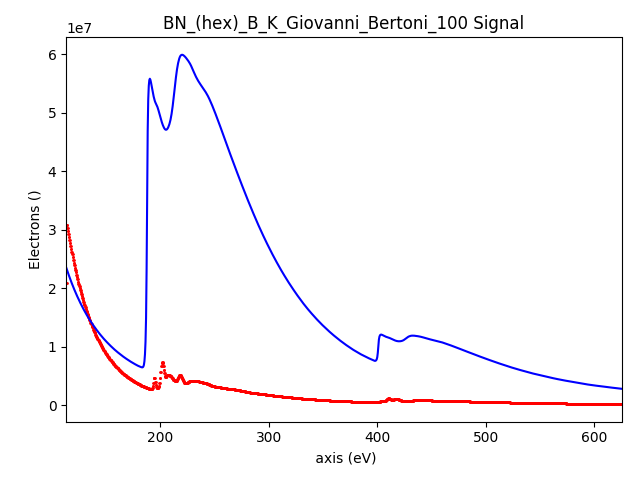

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [185]:
m.plot()

## Perform least squares fitting

<IPython.core.display.Javascript object>


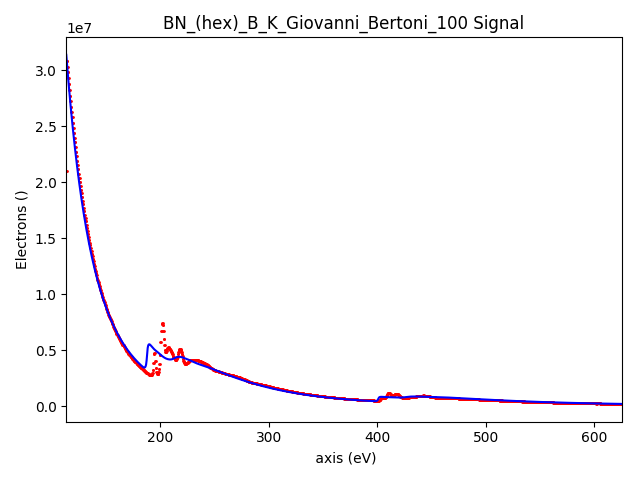

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [186]:
m.smart_fit()
m.plot()

## Perform least-squares fitting with fine structure
- Requires local database of ionization cross-sections
    - Comes with Digital Micrograph
    - Hydrogenic and Hartree-Slater models

<IPython.core.display.Javascript object>


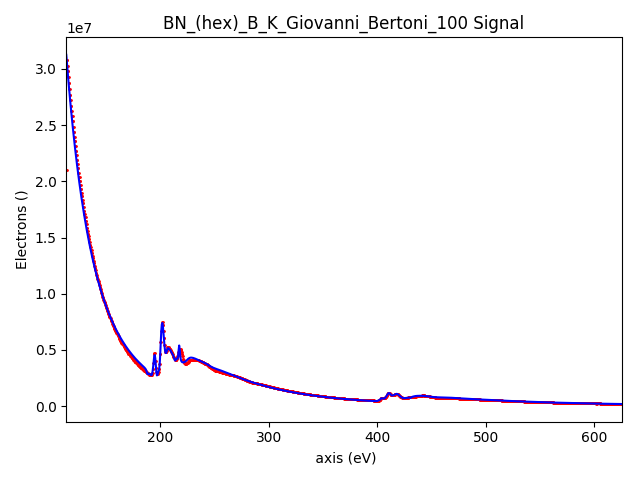

C:\Programs\MiniConda3\envs\tomo\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [187]:
m.enable_fine_structure()
m.smart_fit()
m.plot()